In [3]:
import pandas as pd

# 전처리 CSV 파일 불러오기 
df = pd.read_csv('wildfire_preprocessed_4_logs_target.csv')

# 데이터 첫 5행 확인
print(df.head())

   DSPT_REQ_HR  HR_UNIT_ARTMP  HR_UNIT_HUM  WSPD_BIN  MONTH  \
0          246           -1.0         39.0         1      1   
1          253            5.0         60.0         1      3   
2          643            7.0         49.0         1      3   
3          578            0.3         48.0         3      3   
4          874           -8.7         36.0         5     12   

   CMBS_EXPOBJ_LCLSF_NM_가연성가스  CMBS_EXPOBJ_LCLSF_NM_기타  \
0                           0                        0   
1                           0                        0   
2                           0                        0   
3                           0                        0   
4                           0                        0   

   CMBS_EXPOBJ_LCLSF_NM_미상  CMBS_EXPOBJ_LCLSF_NM_쓰레기류  \
0                        0                          0   
1                        0                          0   
2                        0                          0   
3                        0                  

In [4]:
df.head()

,DSPT_REQ_HR,HR_UNIT_ARTMP,HR_UNIT_HUM,WSPD_BIN,MONTH,CMBS_EXPOBJ_LCLSF_NM_가연성가스,CMBS_EXPOBJ_LCLSF_NM_기타,CMBS_EXPOBJ_LCLSF_NM_미상,CMBS_EXPOBJ_LCLSF_NM_쓰레기류,CMBS_EXPOBJ_LCLSF_NM_위험물등,...,WNDRCT_BRNG_남서,WNDRCT_BRNG_동,WNDRCT_BRNG_북,WNDRCT_BRNG_북동,WNDRCT_BRNG_북서,WNDRCT_BRNG_서,ARRIVAL_DELAY_MIN_LOG,CNTR_GRNDS_DSTNC_LOG,FRSTN_GRNDS_DSTNC_LOG,FIRE_SUPESN_HR_LOG
0,246,-1.0,39.0,1,1,0,0,0,0,0,...,0,0,0,0,1,0,3.044522,1.609438,2.484907,7.090910
1,253,5.0,60.0,1,3,0,0,0,0,0,...,1,0,0,0,0,0,2.397895,1.098612,1.609438,6.398595
2,643,7.0,49.0,1,3,0,0,0,0,0,...,1,0,0,0,0,0,3.230145,1.791759,2.302585,7.284821
3,578,0.3,48.0,3,3,0,0,0,0,0,...,0,0,0,0,1,0,3.276516,1.098612,1.791759,7.333023
4,874,-8.7,36.0,5,12,0,0,0,0,0,...,0,0,0,0,0,1,4.852551,2.397895,3.295837,9.579487


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, cross_val_score, KFold
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import warnings
warnings.filterwarnings('ignore')

In [6]:
# 파일 경로
CSV_PATH = "wildfire_preprocessed_4_logs_target.csv"

# 예측 시점 선택에 따라 누수 변수 포함/제외 토글
# True  -> 도착 이후 시점(허용),  ARRIVAL_DELAY_MIN_LOG 포함
# False -> 발생 직후 시점(비허용), ARRIVAL_DELAY_MIN_LOG 제외
INCLUDE_LEAKY = True

# 데이터 로드
df = pd.read_csv(CSV_PATH)

print(f"행: {len(df):,}, 열: {len(df.columns)}")
print("\n컬럼명:\n", df.columns.tolist()[:50], " ...")
display(df.head())

# 타깃/피처 선택
TARGET = "FIRE_SUPESN_HR_LOG"
if TARGET not in df.columns:
    raise ValueError(f"'{TARGET}' 컬럼이 없습니다.")

# 숫자형 컬럼만 사용(원-핫 완료 가정)
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
feature_cols = [c for c in numeric_cols if c != TARGET]

# 필요 시 누수 변수 제거
if not INCLUDE_LEAKY and "ARRIVAL_DELAY_MIN_LOG" in feature_cols:
    feature_cols.remove("ARRIVAL_DELAY_MIN_LOG")

X = df[feature_cols].copy()
y = df[TARGET].copy()

# 결측치 처리(있으면 행 제거)
mask = ~(X.isnull().any(axis=1) | y.isnull())
X = X[mask]
y = y[mask]

print(f"\n최종 데이터 크기: X={X.shape}, y={y.shape}")
print(f"누수 변수 포함 여부(INCLUDE_LEAKY) = {INCLUDE_LEAKY}")


행: 3,359, 열: 62

컬럼명:
 ['DSPT_REQ_HR', 'HR_UNIT_ARTMP', 'HR_UNIT_HUM', 'WSPD_BIN', 'MONTH', 'CMBS_EXPOBJ_LCLSF_NM_가연성가스', 'CMBS_EXPOBJ_LCLSF_NM_기타', 'CMBS_EXPOBJ_LCLSF_NM_미상', 'CMBS_EXPOBJ_LCLSF_NM_쓰레기류', 'CMBS_EXPOBJ_LCLSF_NM_위험물등', 'CMBS_EXPOBJ_LCLSF_NM_자동차,철도차량,선박,항공기', 'CMBS_EXPOBJ_LCLSF_NM_전기,전자', 'CMBS_EXPOBJ_LCLSF_NM_종이,목재,건초등', 'CMBS_EXPOBJ_LCLSF_NM_침구,직물류', 'CMBS_EXPOBJ_LCLSF_NM_합성수지', 'CMBS_EXPOBJ_LCLSF_NM_nan', 'IGTN_HTSRC_NM_기타(발화원인)', 'IGTN_HTSRC_NM_담뱃불, 라이터불', 'IGTN_HTSRC_NM_마찰, 전도, 복사', 'IGTN_HTSRC_NM_미상(발화원인)', 'IGTN_HTSRC_NM_불꽃, 불티', 'IGTN_HTSRC_NM_자연적 발화열', 'IGTN_HTSRC_NM_작동기기', 'IGTN_HTSRC_NM_폭발물, 폭죽', 'IGTN_HTSRC_NM_화학적 발화열', 'CTPV_NM_강원특별자치도', 'CTPV_NM_경기도', 'CTPV_NM_경상남도', 'CTPV_NM_경상북도', 'CTPV_NM_광주광역시', 'CTPV_NM_대구광역시', 'CTPV_NM_대전광역시', 'CTPV_NM_부산광역시', 'CTPV_NM_서울특별시', 'CTPV_NM_세종특별자치시', 'CTPV_NM_울산광역시', 'CTPV_NM_인천광역시', 'CTPV_NM_전라남도', 'CTPV_NM_전북특별자치도', 'CTPV_NM_제주특별자치도', 'CTPV_NM_충청남도', 'CTPV_NM_충청북도', 'FND_IGTN_PSTN_NM_미상', 'FND_IGTN_PSTN_NM_산아래', 'FND_IGTN

,DSPT_REQ_HR,HR_UNIT_ARTMP,HR_UNIT_HUM,WSPD_BIN,MONTH,CMBS_EXPOBJ_LCLSF_NM_가연성가스,CMBS_EXPOBJ_LCLSF_NM_기타,CMBS_EXPOBJ_LCLSF_NM_미상,CMBS_EXPOBJ_LCLSF_NM_쓰레기류,CMBS_EXPOBJ_LCLSF_NM_위험물등,...,WNDRCT_BRNG_남서,WNDRCT_BRNG_동,WNDRCT_BRNG_북,WNDRCT_BRNG_북동,WNDRCT_BRNG_북서,WNDRCT_BRNG_서,ARRIVAL_DELAY_MIN_LOG,CNTR_GRNDS_DSTNC_LOG,FRSTN_GRNDS_DSTNC_LOG,FIRE_SUPESN_HR_LOG
0,246,-1.0,39.0,1,1,0,0,0,0,0,...,0,0,0,0,1,0,3.044522,1.609438,2.484907,7.090910
1,253,5.0,60.0,1,3,0,0,0,0,0,...,1,0,0,0,0,0,2.397895,1.098612,1.609438,6.398595
2,643,7.0,49.0,1,3,0,0,0,0,0,...,1,0,0,0,0,0,3.230145,1.791759,2.302585,7.284821
3,578,0.3,48.0,3,3,0,0,0,0,0,...,0,0,0,0,1,0,3.276516,1.098612,1.791759,7.333023
4,874,-8.7,36.0,5,12,0,0,0,0,0,...,0,0,0,0,0,1,4.852551,2.397895,3.295837,9.579487



최종 데이터 크기: X=(3359, 61), y=(3359,)
누수 변수 포함 여부(INCLUDE_LEAKY) = True


In [12]:
def optimize_hyperparameters(X, y):
    """
    RandomForest 하이퍼파라미터 그리드 탐색 (5-fold, MSE 기준)
    ※ 회귀에서 'auto'는 비권장/오류 → ['sqrt','log2']만 사용
    """
    print("=== 1단계: 하이퍼파라미터 최적화 시작 ===")
    rf = RandomForestRegressor(random_state=42, n_jobs=-1)

    param_grid = {
        'n_estimators': [100, 200, 400],
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'max_features': ['sqrt', 'log2'],
    }

    gscv = GridSearchCV(
        estimator=rf,
        param_grid=param_grid,
        cv=5,
        scoring='neg_mean_squared_error',  # RMSE를 바로 쓰려면 'neg_root_mean_squared_error'도 가능
        n_jobs=-1,
        verbose=1,
        refit=True,
    )
    gscv.fit(X, y)

    best_params = gscv.best_params_
    best_score_mse = -gscv.best_score_

    print(f"\n최적 하이퍼파라미터: {best_params}")
    print(f"최적 CV MSE: {best_score_mse:,.4f} (RMSE={np.sqrt(best_score_mse):,.4f})")

    return best_params, gscv.best_estimator_

best_params, best_model = optimize_hyperparameters(X, y)


=== 1단계: 하이퍼파라미터 최적화 시작 ===
Fitting 5 folds for each of 216 candidates, totalling 1080 fits

최적 하이퍼파라미터: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 400}
최적 CV MSE: 0.7853 (RMSE=0.8861)


In [13]:
def train_multiple_models(X, y, best_params, n_iterations=10, k_folds=5):
    """
    최적 파라미터 고정 + seed만 바꿔가며 10회 k-fold CV
    RMSE/MAE/R² 평균·표준편차를 저장
    """
    print(f"\n=== 2단계: {n_iterations}회 학습(k={k_folds}) ===")
    results = []
    models = []

    for i in range(n_iterations):
        print(f"\n--- {i+1}번째 모델 학습 ---")
        rf = RandomForestRegressor(**best_params, random_state=42+i, n_jobs=-1)
        kf = KFold(n_splits=k_folds, shuffle=True, random_state=42+i)

        # MSE / R2 / MAE (sklearn은 neg_* 반환 → 부호 반전)
        mse_scores = -cross_val_score(rf, X, y, cv=kf, scoring='neg_mean_squared_error', n_jobs=-1)
        rmse_scores = np.sqrt(mse_scores)
        r2_scores  = cross_val_score(rf, X, y, cv=kf, scoring='r2', n_jobs=-1)
        mae_scores = -cross_val_score(rf, X, y, cv=kf, scoring='neg_mean_absolute_error', n_jobs=-1)

        result = {
            'iteration': i+1,
            'mse_mean': mse_scores.mean(), 'mse_std': mse_scores.std(),
            'rmse_mean': rmse_scores.mean(), 'rmse_std': rmse_scores.std(),
            'r2_mean': r2_scores.mean(),     'r2_std': r2_scores.std(),
            'mae_mean': mae_scores.mean(),   'mae_std': mae_scores.std(),
            'mse_scores': mse_scores, 'rmse_scores': rmse_scores,
            'r2_scores': r2_scores,   'mae_scores': mae_scores
        }
        results.append(result)
        models.append(rf)

        print(f"  RMSE: {rmse_scores.mean():.4f} ± {rmse_scores.std():.4f}")
        print(f"  MAE : {mae_scores.mean():.4f} ± {mae_scores.std():.4f}")
        print(f"  R²  : {r2_scores.mean():.4f} ± {r2_scores.std():.4f}")

    return results, models

results, models = train_multiple_models(X, y, best_params, n_iterations=10, k_folds=5)



=== 2단계: 10회 학습(k=5) ===

--- 1번째 모델 학습 ---
  RMSE: 0.8789 ± 0.0613
  MAE : 0.5372 ± 0.0200
  R²  : 0.6277 ± 0.0262

--- 2번째 모델 학습 ---
  RMSE: 0.8594 ± 0.1004
  MAE : 0.5304 ± 0.0380
  R²  : 0.6444 ± 0.0366

--- 3번째 모델 학습 ---
  RMSE: 0.8767 ± 0.0567
  MAE : 0.5383 ± 0.0228
  R²  : 0.6294 ± 0.0168

--- 4번째 모델 학습 ---
  RMSE: 0.8842 ± 0.0672
  MAE : 0.5432 ± 0.0181
  R²  : 0.6229 ± 0.0174

--- 5번째 모델 학습 ---
  RMSE: 0.8709 ± 0.0455
  MAE : 0.5358 ± 0.0087
  R²  : 0.6341 ± 0.0154

--- 6번째 모델 학습 ---
  RMSE: 0.8702 ± 0.0853
  MAE : 0.5363 ± 0.0272
  R²  : 0.6352 ± 0.0273

--- 7번째 모델 학습 ---
  RMSE: 0.8713 ± 0.0391
  MAE : 0.5375 ± 0.0109
  R²  : 0.6343 ± 0.0080

--- 8번째 모델 학습 ---
  RMSE: 0.8789 ± 0.0474
  MAE : 0.5398 ± 0.0118
  R²  : 0.6271 ± 0.0140

--- 9번째 모델 학습 ---
  RMSE: 0.8680 ± 0.0871
  MAE : 0.5344 ± 0.0376
  R²  : 0.6364 ± 0.0235

--- 10번째 모델 학습 ---
  RMSE: 0.8728 ± 0.0411
  MAE : 0.5358 ± 0.0219
  R²  : 0.6329 ± 0.0157



=== 3단계: 결과 종합 및 분석 ===

전체 10개 모델 성능 요약:
RMSE 평균: 0.8731 ± 0.0066
MAE  평균: 0.5369 ± 0.0032
R²   평균: 0.6324 ± 0.0057

최고 R² 모델: 2번째 (R²=0.6444)
최저 MSE 모델: 2번째 (MSE=0.7486, RMSE=0.8652)


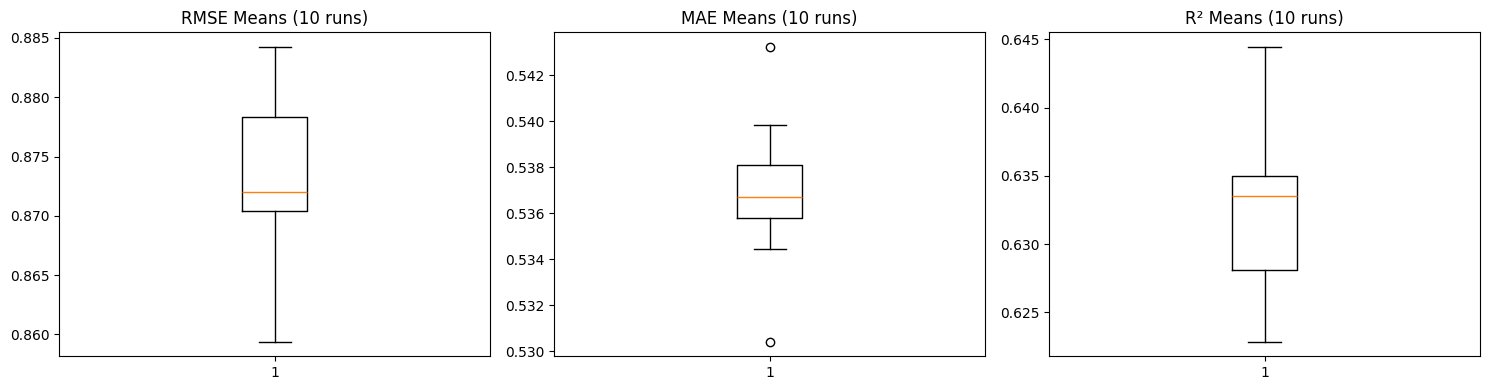

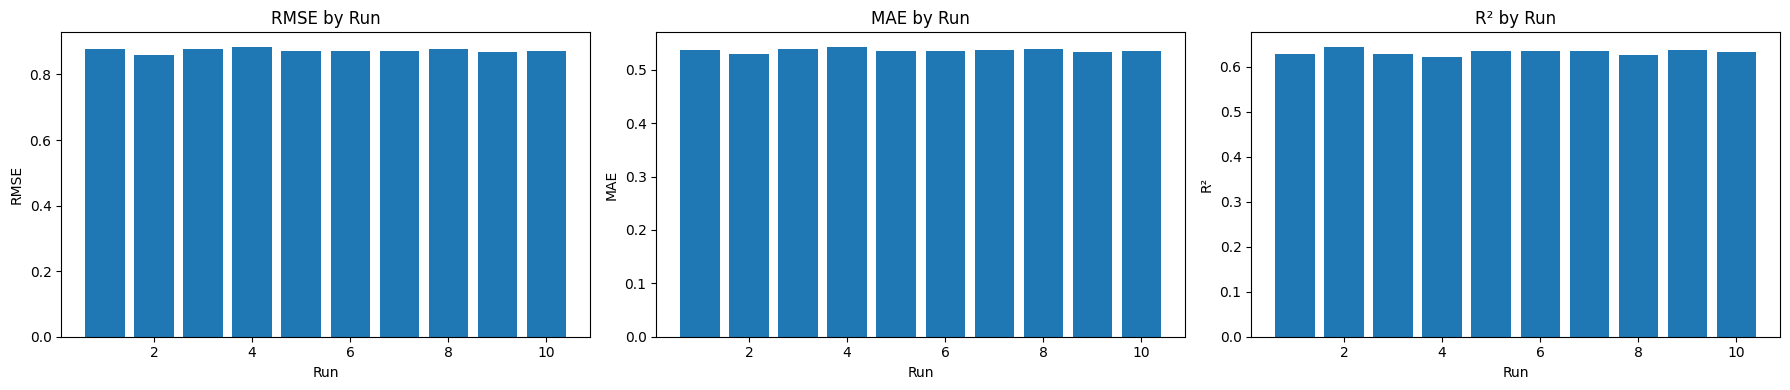


성능 지표 간 상관계수:
          MSE    RMSE     MAE      R2
MSE   1.0000  0.9743  0.9244 -0.9733
RMSE  0.9743  1.0000  0.9470 -0.9990
MAE   0.9244  0.9470  1.0000 -0.9470
R2   -0.9733 -0.9990 -0.9470  1.0000


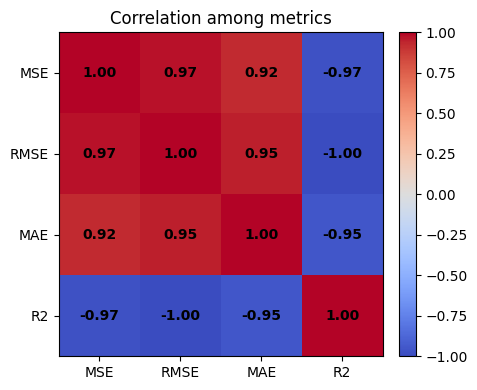

In [12]:
def analyze_results(results):
    print("\n=== 3단계: 결과 종합 및 분석 ===")
    rmse_means = [r['rmse_mean'] for r in results]
    mae_means  = [r['mae_mean']  for r in results]
    r2_means   = [r['r2_mean']   for r in results]
    mse_means  = [r['mse_mean']  for r in results]

    print(f"\n전체 {len(results)}개 모델 성능 요약:")
    print(f"RMSE 평균: {np.mean(rmse_means):.4f} ± {np.std(rmse_means):.4f}")
    print(f"MAE  평균: {np.mean(mae_means):.4f} ± {np.std(mae_means):.4f}")
    print(f"R²   평균: {np.mean(r2_means):.4f} ± {np.std(r2_means):.4f}")

    best_r2_idx  = int(np.argmax(r2_means))
    best_mse_idx = int(np.argmin(mse_means))
    print(f"\n최고 R² 모델: {best_r2_idx+1}번째 (R²={r2_means[best_r2_idx]:.4f})")
    print(f"최저 MSE 모델: {best_mse_idx+1}번째 (MSE={mse_means[best_mse_idx]:.4f}, RMSE={np.sqrt(mse_means[best_mse_idx]):.4f})")

    # --- Boxplot (분포)
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))
    axes[0].boxplot(rmse_means); axes[0].set_title('RMSE Means (10 runs)')
    axes[1].boxplot(mae_means);  axes[1].set_title('MAE Means (10 runs)')
    axes[2].boxplot(r2_means);   axes[2].set_title('R² Means (10 runs)')
    plt.tight_layout(); plt.show()

    # --- Bar plot (비교)
    fig, axes = plt.subplots(1, 3, figsize=(18, 4))
    axes[0].bar(range(1, len(results)+1), rmse_means); axes[0].set_title('RMSE by Run'); axes[0].set_xlabel('Run'); axes[0].set_ylabel('RMSE')
    axes[1].bar(range(1, len(results)+1), mae_means);  axes[1].set_title('MAE by Run');  axes[1].set_xlabel('Run'); axes[1].set_ylabel('MAE')
    axes[2].bar(range(1, len(results)+1), r2_means);   axes[2].set_title('R² by Run');   axes[2].set_xlabel('Run'); axes[2].set_ylabel('R²')
    plt.tight_layout(); plt.show()

    # --- 상관행렬
    corr_df = pd.DataFrame({
        'MSE': mse_means, 'RMSE': rmse_means, 'MAE': mae_means, 'R2': r2_means
    })
    corr = corr_df.corr()
    print("\n성능 지표 간 상관계수:\n", corr.round(4))

    plt.figure(figsize=(5,4))
    im = plt.imshow(corr, cmap='coolwarm', vmin=-1, vmax=1)
    plt.colorbar(im, fraction=0.046, pad=0.04)
    plt.xticks(range(len(corr.columns)), corr.columns)
    plt.yticks(range(len(corr.columns)), corr.columns)
    for i in range(len(corr.columns)):
        for j in range(len(corr.columns)):
            plt.text(j, i, f'{corr.iloc[i, j]:.2f}', ha='center', va='center', color='black', fontweight='bold')
    plt.title('Correlation among metrics')
    plt.tight_layout(); plt.show()

    return best_r2_idx, best_mse_idx

best_r2_idx, best_mse_idx = analyze_results(results)


In [7]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import platform

# OS별 한글 폰트 설정
if platform.system() == 'Darwin':  # Mac
    plt.rc('font', family='AppleGothic')
elif platform.system() == 'Windows':  # Windows
    plt.rc('font', family='Malgun Gothic')
else:  # Linux (예: Colab)
    plt.rc('font', family='NanumGothic')

plt.rcParams['axes.unicode_minus'] = False  # 마이너스 기호 깨짐 방지



=== 특성 중요도 분석 ===

상위 10개 특성 중요도:


,feature,importance
58,ARRIVAL_DELAY_MIN_LOG,0.437245
0,DSPT_REQ_HR,0.066750
60,FRSTN_GRNDS_DSTNC_LOG,0.060032
1,HR_UNIT_ARTMP,0.052640
59,CNTR_GRNDS_DSTNC_LOG,0.050134
2,HR_UNIT_HUM,0.047129
4,MONTH,0.031240
26,CTPV_NM_경기도,0.019316
15,CMBS_EXPOBJ_LCLSF_NM_nan,0.011425
43,FND_IGTN_PSTN_NM_산아래,0.010927


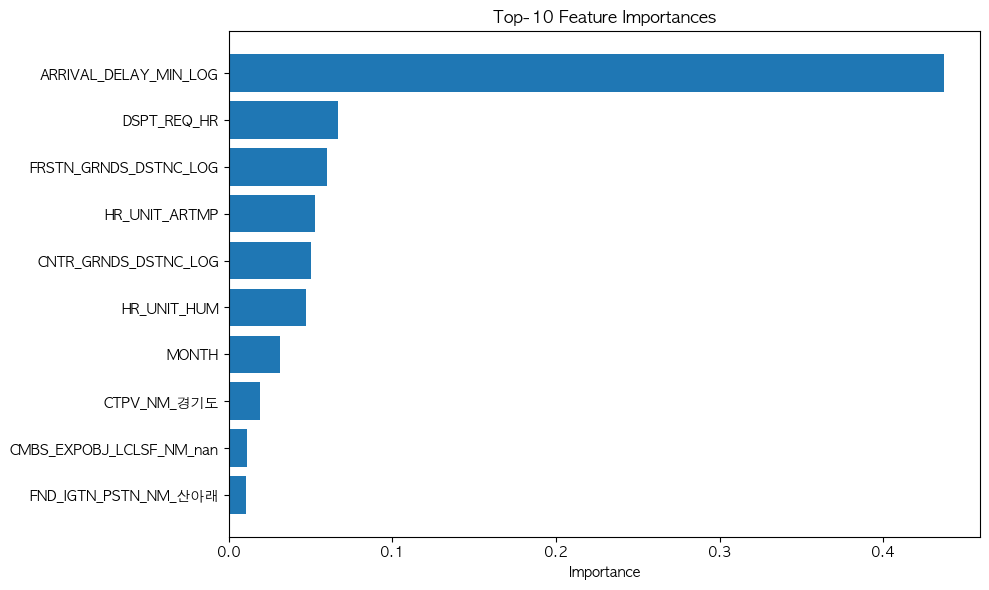

In [14]:
print("\n=== 특성 중요도 분석 ===")
# 최적 모델(best_model)로 전체 데이터 적합 후 중요도 확인
best_model.fit(X, y)
fi = pd.DataFrame({'feature': feature_cols, 'importance': best_model.feature_importances_}) \
        .sort_values('importance', ascending=False)

print("\n상위 10개 특성 중요도:")
display(fi.head(10))

# 시각화
plt.figure(figsize=(10,6))
top = fi.head(10)
plt.barh(range(len(top)), top['importance'])
plt.yticks(range(len(top)), top['feature'])
plt.gca().invert_yaxis()
plt.xlabel('Importance'); plt.title('Top-10 Feature Importances')
plt.tight_layout(); plt.show()


- 최적 하이퍼파라미터: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 400}

In [8]:
# === K-fold CV + 평균 종속변수 시간 계산 (로그/원단위 모두) — 출력 단위: 분/시간 선택 ===
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# -----------------------
# 설정
# -----------------------
TARGET_IS_LOG = True        # 타깃이 로그변환 컬럼이면 True (예: FIRE_SUPESN_HR_LOG)
TIME_UNIT     = "min"       # 출력 단위: 'sec' | 'min' | 'hour'
SHOW_BOTH     = True        # True면 보조 단위(예: 분 선택 시 시간)도 함께 표시

# 모델 하이퍼파라미터 
rf_params = dict(
    n_estimators=400, max_depth=None, max_features='sqrt',
    min_samples_split=2, min_samples_leaf=1,
    random_state=42, n_jobs=-1
)

assert 'X' in globals() and 'y' in globals(), "먼저 X, y를 준비하세요 (이전 셀 참고)."

X_np = np.asarray(X)
y_np = np.asarray(y).astype(float)

# -----------------------
# 헬퍼
# -----------------------
def to_unit(v_sec, unit="sec"):
    if unit == "min":  return v_sec / 60.0
    if unit == "hour": return v_sec / 3600.0
    return v_sec

def unit_label(unit):
    return {"sec":"초", "min":"분", "hour":"시간"}[unit]

def hhmm(v_sec):
    v_sec = float(v_sec)
    h = int(v_sec // 3600)
    m = int((v_sec % 3600) // 60)
    return f"{h}h {m}m"

def show_with_both(name, v_sec):
    main_val = to_unit(v_sec, TIME_UNIT)
    s = f"{name}: {main_val:,.2f} {unit_label(TIME_UNIT)}"
    if SHOW_BOTH:
        other_unit = {"sec":"min", "min":"hour", "hour":"min"}[TIME_UNIT]
        other_val  = to_unit(v_sec, other_unit)
        s += f"  |  ({other_val:,.2f} {unit_label(other_unit)}, ~{hhmm(v_sec)})"
    return s

# -----------------------
# K-fold CV (로그 스케일 성능)
# -----------------------
kf = KFold(n_splits=5, shuffle=True, random_state=42)

y_true_list_log, y_pred_list_log = [], []
rmse_list_log, mae_list_log, r2_list_log = [], [], []

for fold_idx, (tr, va) in enumerate(kf.split(X_np), start=1):
    X_tr, X_va = X_np[tr], X_np[va]
    y_tr, y_va = y_np[tr], y_np[va]

    model = RandomForestRegressor(**rf_params)
    model.fit(X_tr, y_tr)
    y_va_pred = model.predict(X_va)

    rmse_log = np.sqrt(mean_squared_error(y_va, y_va_pred))
    mae_log  = mean_absolute_error(y_va, y_va_pred)
    r2_log   = r2_score(y_va, y_va_pred)

    rmse_list_log.append(rmse_log)
    mae_list_log.append(mae_log)
    r2_list_log.append(r2_log)

    y_true_list_log.append(y_va)
    y_pred_list_log.append(y_va_pred)

    print(f"[Fold {fold_idx}] RMSE={rmse_log:.4f} | MAE={mae_log:.4f} | R²={r2_log:.4f}")

# -----------------------
# fold 전체 합치기
# -----------------------
y_all_true_log = np.concatenate(y_true_list_log)
y_all_pred_log = np.concatenate(y_pred_list_log)

print("\n=== CV 평균(로그 스케일, y의 현재 스케일 기준) ===")
print(f"RMSE(mean±std): {np.mean(rmse_list_log):.4f} ± {np.std(rmse_list_log):.4f}")
print(f"MAE (mean±std): {np.mean(mae_list_log):.4f} ± {np.std(mae_list_log):.4f}")
print(f"R²  (mean±std): {np.mean(r2_list_log):.4f} ± {np.std(r2_list_log):.4f}")

# -----------------------
# 원 단위(초)로 복원 후 통계/지표
# -----------------------
if TARGET_IS_LOG:
    y_all_true_sec = np.expm1(y_all_true_log)
    y_all_pred_sec = np.expm1(y_all_pred_log)
else:
    y_all_true_sec = y_all_true_log
    y_all_pred_sec = y_all_pred_log

# 실제/예측 통계
mean_true    = float(np.mean(y_all_true_sec))
median_true  = float(np.median(y_all_true_sec))
std_true     = float(np.std(y_all_true_sec))

mean_pred    = float(np.mean(y_all_pred_sec))
median_pred  = float(np.median(y_all_pred_sec))  # ✅ 예측 중앙값 추가

# 오차 지표 (원 단위 기준)
rmse_orig = float(np.sqrt(mean_squared_error(y_all_true_sec, y_all_pred_sec)))
mae_orig  = float(mean_absolute_error(y_all_true_sec, y_all_pred_sec))
r2_orig   = float(r2_score(y_all_true_sec, y_all_pred_sec))  # 역변환 후 R²는 참고용

print(f"\n=== 실제 종속변수 통계 (표시 단위 → {unit_label(TIME_UNIT)}) ===")
print(show_with_both("평균",     mean_true))
print(show_with_both("중앙값",   median_true))
print(show_with_both("표준편차", std_true))

print(f"\n=== 예측 통계 (표시 단위 → {unit_label(TIME_UNIT)}) ===")
print(show_with_both("예측 평균",    mean_pred))
print(show_with_both("예측 중앙값",  median_pred))  # ✅ 출력 추가
print(show_with_both("평균 차이(예측-실제)",   mean_pred - mean_true))
print(show_with_both("중앙값 차이(예측-실제)", median_pred - median_true))  # ✅ 차이도 출력

print(f"\n=== 원래 단위에서의 오차 지표 (참고) ===")
print(show_with_both("RMSE", rmse_orig))
print(show_with_both("MAE",  mae_orig))
print(f"R²  : {r2_orig:.4f}  (역변환 후 R²는 참고용)")


[Fold 1] RMSE=0.8413 | MAE=0.5338 | R²=0.6519
[Fold 2] RMSE=0.8750 | MAE=0.5374 | R²=0.6073
[Fold 3] RMSE=0.8378 | MAE=0.5283 | R²=0.6591
[Fold 4] RMSE=0.9985 | MAE=0.5735 | R²=0.5897
[Fold 5] RMSE=0.8417 | MAE=0.5129 | R²=0.6305

=== CV 평균(로그 스케일, y의 현재 스케일 기준) ===
RMSE(mean±std): 0.8789 ± 0.0613
MAE (mean±std): 0.5372 ± 0.0200
R²  (mean±std): 0.6277 ± 0.0262

=== 실제 종속변수 통계 (표시 단위 → 분) ===
평균: 112.03 분  |  (1.87 시간, ~1h 52m)
중앙값: 59.22 분  |  (0.99 시간, ~0h 59m)
표준편차: 184.58 분  |  (3.08 시간, ~3h 4m)

=== 예측 통계 (표시 단위 → 분) ===
예측 평균: 70.18 분  |  (1.17 시간, ~1h 10m)
예측 중앙값: 59.90 분  |  (1.00 시간, ~0h 59m)
평균 차이(예측-실제): -41.85 분  |  (-0.70 시간, ~-1h 18m)
중앙값 차이(예측-실제): 0.68 분  |  (0.01 시간, ~0h 0m)

=== 원래 단위에서의 오차 지표 (참고) ===
RMSE: 165.29 분  |  (2.75 시간, ~2h 45m)
MAE: 57.82 분  |  (0.96 시간, ~0h 57m)
R²  : 0.1981  (역변환 후 R²는 참고용)
